# Predicting the next word

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

For this task we will use the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [ ]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 91.2MB/s]


In [ ]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In this function we need to process this corpus one line at a time.

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

## Generating n_grams

This function receives the fitted tokenizer and the corpus (which is a list of strings) and returns a list containing the `n_gram` sequences for each line in the corpus:

In [ ]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for ln in corpus:
        tkn_list = tokenizer.texts_to_sequences([ln])[0]
        for i in range(1, len(tkn_list)):
            aux = tkn_list[:i+1]
            input_sequences.append(aux)
    return input_sequences

In [ ]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)
print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:


[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [ ]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)
print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:


[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [ ]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

the `pad_seqs` function pads any given sequences to the desired maximum length.

In [ ]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = np.array(pad_sequences(input_sequences,maxlen = maxlen))
    return padded_sequences

In [ ]:
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

In [ ]:
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [ ]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

Before feeding the data into the neural network we should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

This function expects the padded n_gram sequences as input and returns a tuple containing the features and the one hot encoded labels.

In [ ]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

In [ ]:
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:


array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]], dtype=int32)

In [ ]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

Now we define a model architecture capable of achieving an accuracy of at least 80%.

In [ ]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(total_words, activation = 'softmax'))


    # Compile the model
    model.compile(loss= 'categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

    return model

In [ ]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 8s 10ms/step - loss: 6.8480 - accuracy: 0.0228
Epoch 2/50
484/484 [==============================] - 5s 10ms/step - loss: 6.4361 - accuracy: 0.0315
Epoch 3/50
484/484 [==============================] - 5s 10ms/step - loss: 6.2244 - accuracy: 0.0399
Epoch 4/50
484/484 [==============================] - 5s 10ms/step - loss: 5.9814 - accuracy: 0.0511
Epoch 5/50
484/484 [==============================] - 5s 10ms/step - loss: 5.6976 - accuracy: 0.0590
Epoch 6/50
484/484 [==============================] - 5s 10ms/step - loss: 5.3800 - accuracy: 0.0716
Epoch 7/50
484/484 [==============================] - 5s 10ms/step - loss: 5.0429 - accuracy: 0.0868
Epoch 8/50
484/484 [==============================] - 5s 10ms/step - loss: 4.6790 - accuracy: 0.1080
Epoch 9/50
484/484 [==============================] - 5s 10ms/step - loss: 4.3147 - accuracy: 0.1392
Epoch 10/50
484/484 [==============================] - 5s 10ms/step - loss: 3.9626 - accura

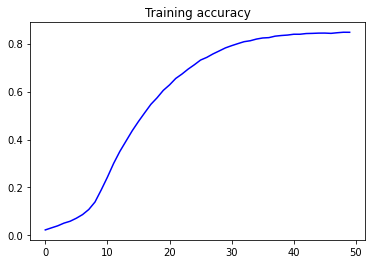

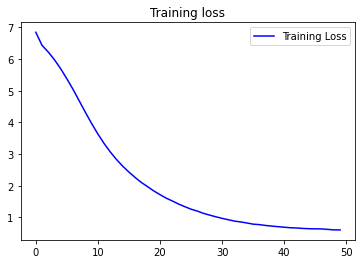

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## See the model in action

After all  work it is finally time to see model generating text.

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope and my heart his treasure gain behind his wit fame truth ' more ' a face unrespected but on thee memory left behind thee head again hate light ushers men will store me wrong than brows worse more strong find now spend spend four learn seething blind makest brave son die thee still do behind not live ' a tomb the ocean cross ' of her lies i hate lie so thee thee see not so see me as i thence thy friend slain you live thee ' lies ' more back of thee now live lose life rare '
